<a href="https://colab.research.google.com/github/polnops/adiabatic_loading/blob/master/tweezer_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import os
import itertools
import numpy as np
import pickle

import matplotlib.animation as animation
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from google.colab import drive
from matplotlib import cycler

#drive.mount('/content/gdrive')

plt.style.use('classic')
plt.gcf().subplots_adjust(bottom=0.15)

IPython_default = plt.rcParams.copy()
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none', 
       labelcolor='black', labelsize = 12,
       axisbelow=True, prop_cycle=colors)
       
plt.rc('grid', color='b', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

<Figure size 640x480 with 0 Axes>

In [119]:
class Dynamics1D(object):
    '''solves ODE for the dynamics of a single particle in a time-varing potential'''

    def __init__(self, n = int(5e3), t_len = 40, V0 = 200):
        
        self.n     = n
        self.t     = np.linspace(-t_len, t_len, n)      
        self.x     = np.empty_like(self.t)
        self.p     = np.empty_like(self.t)   
        self.V0    = V0
        self.trapfunction = 'gaussian' #'harmonic'
    
    def _rampOmega(self):
        self.omega = (self.omega_i + self.omega_f)/2.0 \
              - (self.omega_i - self.omega_f)/2.0* \
             np.arctan(self.t/self.tau)/(np.pi/2.0)  

    def V_trap(self, omega, x):
        
        if self.trapfunction == 'gaussian':
            return -self.V0*np.exp(-(omega*x)**2)
        elif self.trapfunction == 'harmonic':
            return self.V0*0.5*(omega*x)**2

    def dV_trap(self, omega, x):

        if self.trapfunction == 'gaussian':
            return self.V0*2*(omega**2)*x*np.exp(-(omega*x)**2)
        elif self.trapfunction == 'harmonic':
            return self.V0*(omega**2)*x

    def d2V_trap(self, omega, x):

        if self.trapfunction == 'gaussian':
            return self.V0*(2*(omega**2)-4*(omega**4)*x**2)*np.exp(-(omega*x)**2)
        elif self.trapfunction == 'harmonic':
            return self.V0*(omega**2)

    def _model(self, z, t, omega):
        x, p = z
        dxdt = p
        dpdt = -self.dV_trap(omega,x)
        return [dxdt, dpdt]

    def _jacobian(self, z, t, omega):
        x, p = z
        J = [[0,1],[-self.d2V_trap(omega,x),0]]
        return np.transpose(np.array(J))
        #return np.array(J)

    def solveODE(self, omega_i = 5, omega_f = 1, tau = 10, z0 = [0, 0.25]):
        
        self.x[0], self.p[0] = z0
        self.tau     = tau
        self._rampOmega()
        for i in range(1, self.n):
            tspan = [self.t[i-1], self.t[i]]
            z     = odeint(self._model, z0, tspan, args=(self.omega[i],), 
                           Dfun=self._jacobian, col_deriv= 1)
            self.x[i] = z[1][0]
            self.p[i] = z[1][1]
            z0        = z[1]

    def plot_xp(self):

        plt.figure(figsize=(15,2))
        plt.plot(self.t,self.omega,lw=4)
        plt.ylabel('freq')
        plt.figure(figsize=(15,2))
        plt.plot(self.t,self.x,label='x(t)')
        plt.plot(self.t,self.p,label='p(t)')
        plt.ylabel('values')
        plt.xlabel('time')
        plt.legend(loc='best')
        plt.show()

    def energy(self):
        self.KE       = 0.5*(self.p)**2
        self.PE       = self.V_trap(self.omega,self.x)
        self.E_total  = self.KE + self.PE
        self.loss     = (self.E_total[-1] >= 0)

    def plotEnergy(self):
        self.energy()
        plt.figure(figsize=(10,2))
        plt.plot(self.t,self.KE ,label='K.E')
        plt.plot(self.t,self.PE,label='P.E')
        plt.plot(self.t,self.E_total,label='total',lw=4)
        plt.ylabel('energy')
        plt.xlabel('time')
        plt.legend(loc='best')
        plt.show()

    def setV0(self,V0):
        self.V0 = V0

    def setOmegas(self,omega_i,omega_f):
        self.omega_i = omega_i
        self.omega_f = omega_f
        
    def plot_animation(self, savepath = 'adia1d.mp4'):
    
        width = 3
        fig = plt.figure()
        
        if self.trapfunction == 'gaussian':
            ylim=(-1.5, 0.25)
        elif self.trapfunction == 'harmonic':
            ylim=(0, 10)

        ax = plt.axes(xlim=(-width, width), ylim=(-1.5, 0.25))
        line, = ax.plot([], [], lw=3)
        line2, = ax.plot([], [], marker='o',linestyle='None',markersize=12)

        def animate(i):

            xplot = np.linspace(-width,width,100)
            line.set_data(xplot, self.V_trap(self.omega[i],xplot))
            line2.set_data(self.x[i], self.V_trap(self.omega[i],self.x[i]))
            return line, line2

        anim = animation.FuncAnimation(fig, animate, frames=self.n, 
                                        interval=20, blit=True)
        anim.save(savepath)

        plt.show()

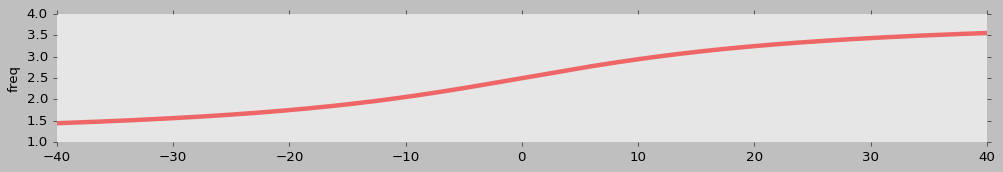

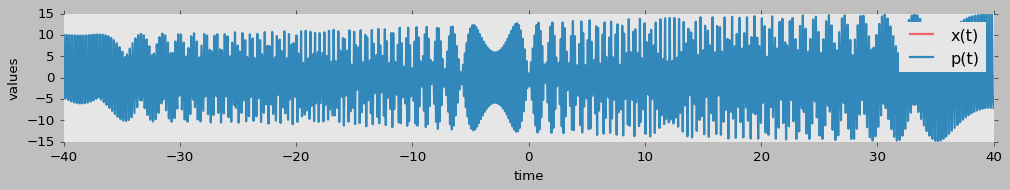

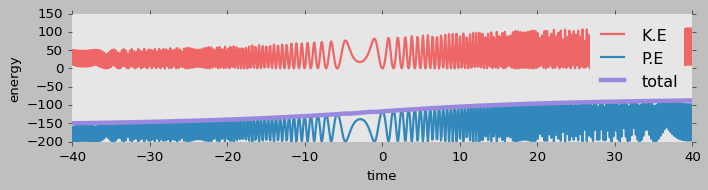

In [120]:
h1d = Dynamics1D(V0 = 200)
h1d.setOmegas(omega_i = 1, omega_f = 4)
h1d.solveODE(tau = 20, z0 = [0,10])
h1d.plot_xp()
h1d.plotEnergy()

In [121]:
# path = '/content/gdrive/My Drive/Atom_cavity/personal folders/Po/adiabatic_cooling'
# os.chdir(path)
# h1d.plot_animation(savepath = 'gaussian.mp4')

In [122]:
class ThermalLoss(Dynamics1D):
    '''determines loss probability for a given set of initial conditions. for a temperature sweep, 
    we only need to do this once. however, if we want to change the frequeny sweep function, we'll 
    need to redo this.'''
    def __init__(self):
        super(ThermalLoss, self).__init__()


    def _boltzmannProb(self,x0, p0, omega, kT = 1):
        E0 = 0.5*p0**2 + self.V_trap(omega,x0)
        return np.exp(-E0/kT)

    def getLossMap(self, x0_arr, p0_arr, tau = 20):

            m = len(x0_arr); n = len(p0_arr)                 
            init2dloss = np.zeros((m,n)) 
            for i, j in itertools.product(range(m), range(n)):      
              x0 = x0_arr[i]; p0 = p0_arr[j];
              #can't easily vectorize this (with x0 = x0_arr, p0 = p0_arr[:,None]) for some reason...
              self.solveODE(tau = tau, z0 = [x0, p0])
              self.energy()
              init2dloss[i,j] = self.loss

            return init2dloss

    def getLossMapAdia(self, x0_arr, p0_arr):
    #same as getLossMap with extra assumptions: 1. adiabatic and 2. harmonic with cutoff 
    
        self.x = x0_arr #note self.x/p now has a distinct structure from the rest of the code
        self.p = p0_arr

        self.omega    = self.omega_i
        self.energy()
        #have to readjust the loss condition with offset
        final_total   = (self.omega_f/self.omega_i)*(self.E_total + self.V0)     
        init2dloss    = (final_total - self.V0 >= 0)

        return init2dloss

    def thermalLoss(self, x_max = 20, p_max = 20, kT = [1], 
                    fast = True, resolution = [20,20], plot = False):

        m = resolution[0]; n = resolution[1];
        
        x0_arr = np.linspace(0,x_max,m) #only need to do positive side due to symmetry
        p0_arr = np.linspace(0,p_max,n)
        
        if fast:
          self.getLossMapAdia(x0_arr, p0_arr)
          init2dloss = self.loss
        else:
          init2dloss = self.getLossMap(x0_arr, p0_arr, tau = 20)

        losses_vs_T = []

        #determine initial thermal distribution
        for kTi in kT: 
            p_boltzmann = self._boltzmannProb(x0_arr[:,None], p0_arr, omega = self.omega_i, kT = kTi)
            p_boltzmann *= 1/np.sum(p_boltzmann)
            loss_prob = np.sum(init2dloss*p_boltzmann)
            losses_vs_T.append(loss_prob)

        if plot:
            for dat in [init2dloss, p_boltzmann]:
              lrtb = (0, p_max, x_max, 0) 
              plt.figure(figsize=(4,6))
              #print(dat)
              plt.imshow(dat, aspect = 'auto', extent = lrtb, interpolation = 'None')
              plt.xlabel('p')
              plt.ylabel('x')
              plt.show()
        return np.array(losses_vs_T)


AttributeError: ignored

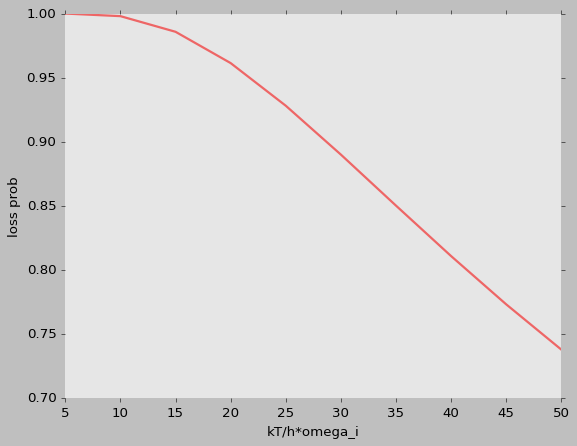

In [131]:
therm = ThermalLoss()
kT = np.linspace(5,50,10)
therm.setOmegas(omega_i = 1, omega_f = 5)

for npoints in [5,20,50]:
  loss = therm.thermalLoss(x_max = 1.2, p_max = 30, kT = kT, fast = False, resolution = [npoints,npoints], plot = False)

  plt.plot(kT,1-loss, label = npoints)
  plt.xlabel('kT/h*omega_i')
  plt.ylabel('loss prob')
  plt.legend()

plot.show()

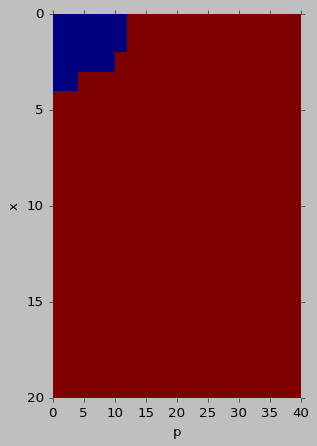

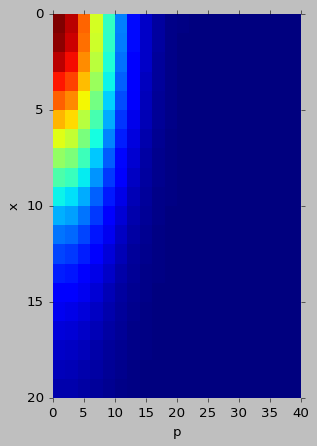

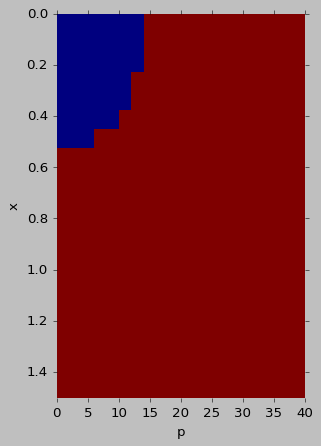

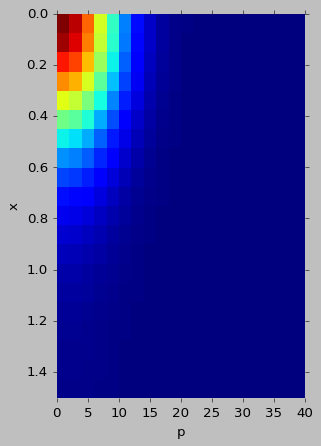

Text(0, 0.5, 'loss prob')

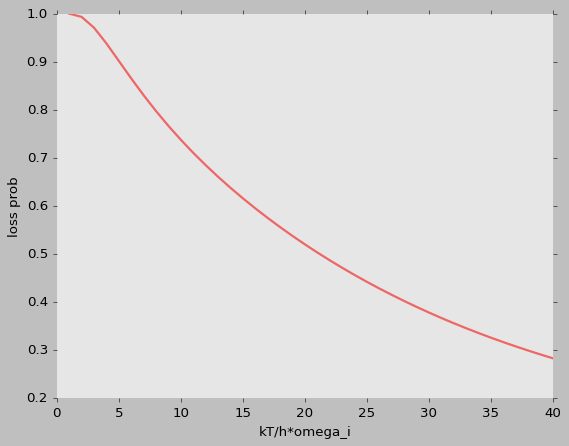

In [127]:
therm = ThermalLoss()
kT = np.linspace(1,40,40)
therm.setOmegas(omega_i = 1/20, omega_f = 1)
loss_ax = therm.thermalLoss(x_max = 20, p_max = 40, kT = kT, fast = False, plot = True)

therm.setOmegas(omega_i = 1, omega_f = 5)
loss_rad = therm.thermalLoss(x_max = 1.5, p_max = 40, kT = kT, fast = False, plot = True)

recap_total = (1-loss_ax)*(1-loss_rad)

plt.plot(kT,recap_total)
plt.xlabel('kT/h*omega_i')
plt.ylabel('loss prob')

In [130]:
print(kT, recap_total)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40.] [0.99989721 0.99307093 0.97051679 0.9377461  0.90132567 0.86483668
 0.82984025 0.79686923 0.765985   0.73705537 0.70988591 0.68427834
 0.66005384 0.63705992 0.61517017 0.59428114 0.57430847 0.55518314
 0.53684825 0.51925625 0.50236678 0.48614499 0.4705602  0.45558487
 0.4411939  0.42736399 0.41407329 0.40130106 0.38902746 0.37723342
 0.36590048 0.35501081 0.34454708 0.33449248 0.32483069 0.3155459
 0.30662274 0.29804637 0.2898024  0.28187695]


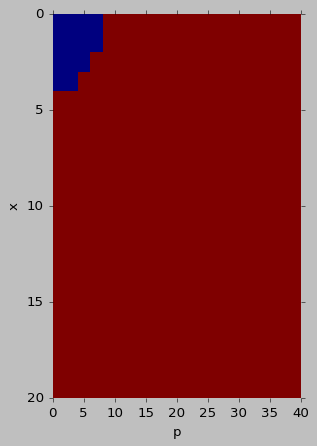

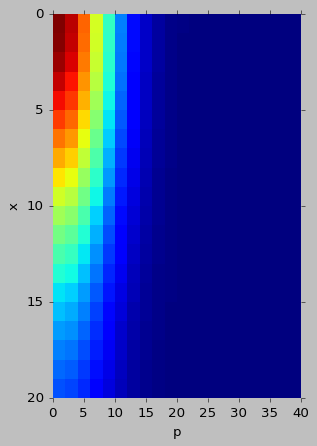

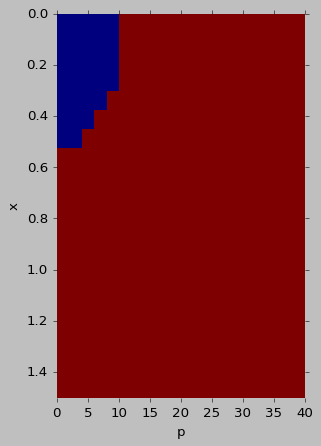

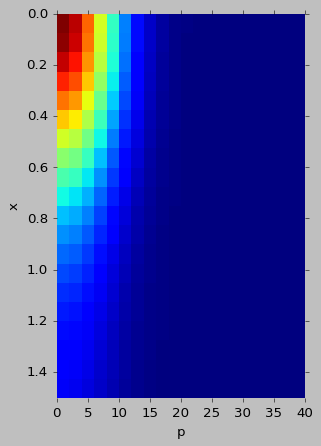

In [ ]:
for V in [100,200,300]:

  therm = ThermalLoss()
  therm.setV0(V)

  kT = np.linspace(1,40,40)
  therm.setOmegas(omega_i = 1/20, omega_f = 1)
  loss_ax = therm.thermalLoss(x_max = 20, p_max = 40, kT = kT, fast = False, plot = True)

  therm.setOmegas(omega_i = 1, omega_f = 5)
  loss_rad = therm.thermalLoss(x_max = 1.5, p_max = 40, kT = kT, fast = False, plot = True)

  recap_total = (1-loss_ax)*(1-loss_rad)

  plt.plot(kT,recap_total,label = V0)
  plt.xlabel('kT/h*omega_i')
  plt.ylabel('loss prob')
  plt.legends
plt.show()

In [ ]:
class Adiabaticity1D(Dynamics1D):
    '''determines adiabaticity from the parcitle dynamics. need the solution to ODE form Dynamics1D'''


    def __init__(self, n = 1001, t_len = 40):

        super(Adiabaticity1D, self).__init__(n, t_len)
        
    def _strided_app(self, a, window_len, stride):  
        nrows = ((a.size-window_len)//stride)+1
        n = a.strides[0]
        return np.lib.stride_tricks.as_strided(a, shape=(nrows,window_len), 
                                               strides=(stride*n,n))

    def phasespaceVol(self, t_window = 30, stride = 5):
        self.t_sampled = np.mean(self._strided_app(self.t,t_window,stride),axis=1)
        self.dx = np.std(self._strided_app(self.x,t_window,stride),axis=1)
        self.dp = np.std(self._strided_app(self.p,t_window,stride),axis=1)
        self.dV = self.dx*self.dp
    
    def plotvoltrace(self):
        self.phasespaceVol(t_window = 40, stride = 3)
        plt.figure(figsize=(10,2))
        plt.plot(self.t_sampled,self.dx,'g-',label='dx',lw=4)
        plt.plot(self.t_sampled,self.dp,'b-',label='dp')
        plt.plot(self.t_sampled,self.dV/max(self.dV),'r--',label='phase space vol')
        plt.ylabel('values')
        plt.xlabel('time')
        plt.legend(loc='best')
        plt.show()
        
    def adiabaticityMap(self, n = 50, power_min = -1, power_max = 3):

        adia2d = []
        tau_list = 10**np.linspace(power_min, power_max,n)

        maxVol = max(self.dV)
        
        for tau0 in tau_list:
            self.solveODE(tau = tau0)
            self.phasespaceVol(t_window = 40, stride = 3)
            adia2d.append([self.dx,self.dp,self.dV/maxVol])

        self.adiabaticmap = np.array(adia2d)[:,2,:]

        x,y = np.meshgrid(adia.t_sampled, tau_list)
        m,n = np.shape(self.adiabaticmap)

        plt.pcolormesh(x,y,self.adiabaticmap)
        plt.yscale('log',basey=10)
        plt.ylabel("tau")
        plt.xlabel("time")
        plt.colorbar()
        plt.show()


In [ ]:
adia = Adiabaticity1D()
adia.solveODE(tau = 1)
adia.plot_xp()
adia.plotvoltrace()

In [ ]:
adia.adiabaticityMap()